### ***Main info*** ###

***Project description:*** https://www.kaggle.com/competitions/bike-sharing-demand/overview/description

***Project goal:*** combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

***Notebook goal:*** test LSTM methods, make blueprint for future experiments 

<p>

### ***0. Project preparation*** ###

---

In [92]:
# basic imports
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from math import sqrt
import statsmodels.api as sm
plt.style.use('ggplot')
%matplotlib inline

In [280]:
# keras imports
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense, Bidirectional

from keras.preprocessing.sequence import TimeseriesGenerator

In [94]:
# set same seed to everything
SEED_VALUE= 0
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

### ***1. Load data*** ###

---

In [95]:
df_train = pd.read_csv('inputs/train.csv', parse_dates = ['datetime'], index_col = 'datetime')
df_test = pd.read_csv('inputs/test.csv', parse_dates = ['datetime'], index_col = 'datetime')

In [96]:
df_train

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
...                     ...      ...         ...      ...    ...     ...   
2012-12-19 19:00:00       4        0           1        1  15.58  19.695   
2012-12-19 20:00:00       4        0           1        1  14.76  17.425   
2012-12-19 21:00:00       4        0           1        1  13.94  15.910   
2012-12-19 22:00:00       4        0           1        1  13.94  17.425   
2012-12-19 23:00:00       4        0           1        1  13.12  16.665   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81     0.0000       3          13     16  
2011-01-01 01:00:00        80     0.0000       8          32     40  
2011-01-01 02:00:00        80     0.0000       5          27     32  
2011-01-01 03:00:00        75     0.0000       3          10     13  
2011-01-01 04:00:00        75     0.0000       0           1      1  
...                       ...        ...     ...         ...    ...  
2012-12-19 19:00:00        50    26.0027       7         329    336  
2012-12-19 20:00:00        57    15.0013      10         231    241  
2012-12-19 21:00:00        61    15.0013       4         164    168  
2012-12-19 22:00:00        61     6.0032      12         117    129  
2012-12-19 23:00:00        66     8.9981       4          84     88  

[10886 rows x 11 columns]

In [97]:
df_test

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
2011-01-20 04:00:00       1        0           1        1  10.66  12.880   
...                     ...      ...         ...      ...    ...     ...   
2012-12-31 19:00:00       1        0           1        2  10.66  12.880   
2012-12-31 20:00:00       1        0           1        2  10.66  12.880   
2012-12-31 21:00:00       1        0           1        1  10.66  12.880   
2012-12-31 22:00:00       1        0           1        1  10.66  13.635   
2012-12-31 23:00:00       1        0           1        1  10.66  13.635   

                     humidity  windspeed  
datetime                                  
2011-01-20 00:00:00        56    26.0027  
2011-01-20 01:00:00        56     0.0000  
2011-01-20 02:00:00        56     0.0000  
2011-01-20 03:00:00        56    11.0014  
2011-01-20 04:00:00        56    11.0014  
...                       ...        ...  
2012-12-31 19:00:00        60    11.0014  
2012-12-31 20:00:00        60    11.0014  
2012-12-31 21:00:00        60    11.0014  
2012-12-31 22:00:00        56     8.9981  
2012-12-31 23:00:00        65     8.9981  

[6493 rows x 8 columns]

### ***2. Custom feature functions*** ###

---

In [98]:
def between_dates(dataset: pd.DataFrame, start_date: str, start_time: str, end_date: str, end_time: str) -> pd.DataFrame:
    '''
    Show dataframe between two dates and timestamps
    
    Arguments:
        dataset: pandas DataFrame 
        start_date: date which the dataset must be trimmed from
        start_time: hour of day from start_date
        end_date: date which the dataset must be trimmed to
        end_time: hour of day from end_date

    Returns:
        A DataFrame between (start_date, start_time) and (end_date, end_time)
    '''

    start_dt = f'{start_date} {start_time}:00:00'
    end_dt = f'{end_date} {end_time}:00:00'
    mask = (dataset.index >= start_dt) & (dataset.index <= end_dt)
    return dataset[mask]

In [99]:
def select_test(year: int, month: int) -> pd.DataFrame:
  '''
  Return a dataframe of test dataset given a year and a month

  Arguments:
        year: year of dataset
        month: month of a given year

  Returns:
        A part of test dataset when datetime column corresponds to a given year and month
  '''
  next_month = month + 1
  if next_month == 13:
    next_month = 1
  month = str(month).zfill(2)
  next_month = str(next_month).zfill(2)

  if  month != '12':
    result = between_dates(df_test, f'{year}-{month}-01', '00', f'{year}-{next_month}-01', '00')
  else:
    result = between_dates(df_test, f'{year}-{month}-01', '00', f'{year+1}-{next_month}-01', '00')
  
  return result

In [101]:
def select_train(year: int, month: int) -> pd.DataFrame:
    '''
    Return a dataframe of train dataset given a year and a month

    Arguments:
            year: year of dataset
            month: month of a given year

    Returns:
            A part of teain dataset when datetime column corresponds to a given year and month
    '''

    month = str(month).zfill(2)
    result = between_dates(df_train, f'{year}-{month}-01', '00', f'{year}-{month}-20', '00')
        
    return result 

### ***3. Visualise training datasets in every month*** ###

---

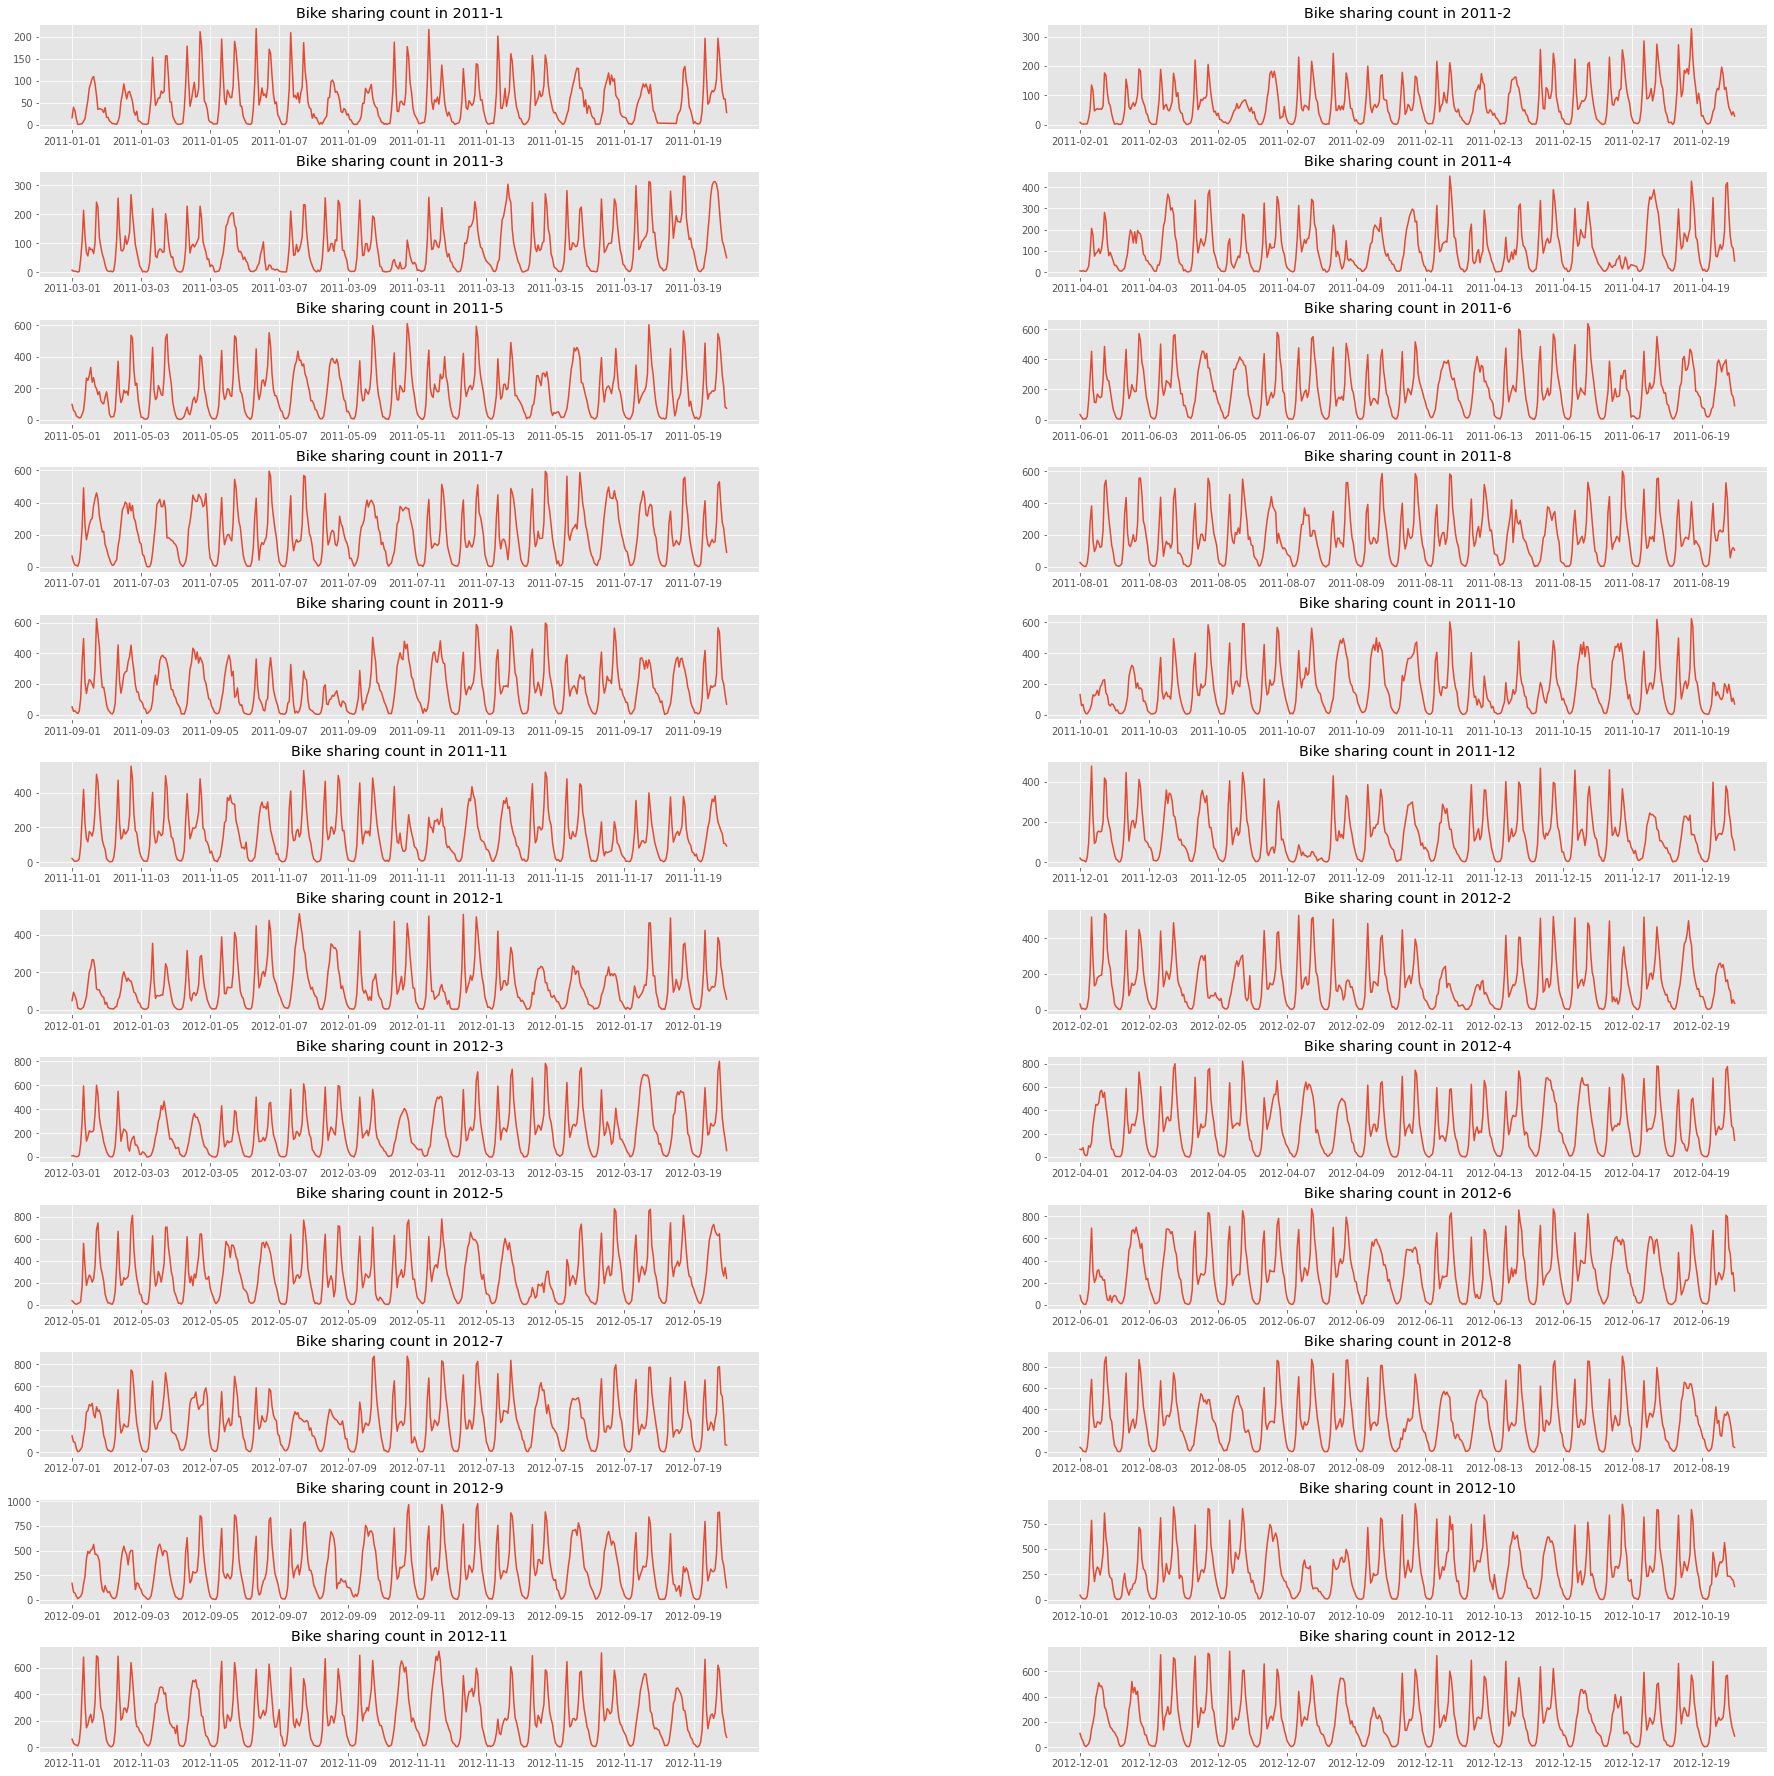

In [103]:
years = [2011, 2012] # all years
months = list(range(1, 13)) # months from 1 to 12

calendar = list(product(years, months))

plt.figure(figsize = (30,30));
for e, c in enumerate(calendar, 1):
    plt.subplot(12,2, e)
    plt.plot(select_train(c[0], c[1])['count'])
    plt.title(f'Bike sharing count in {c[0]}-{c[1]}');
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

C:\Users\mariu\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


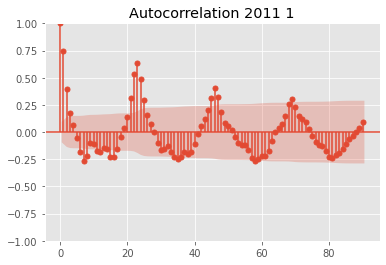

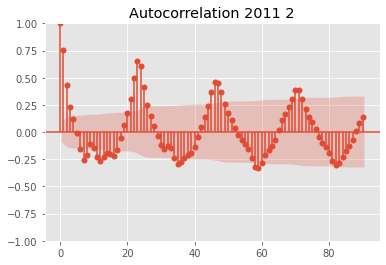

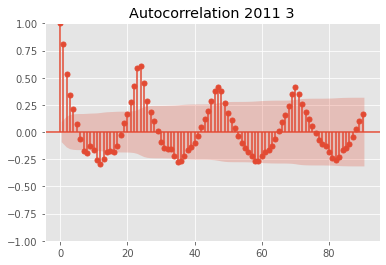

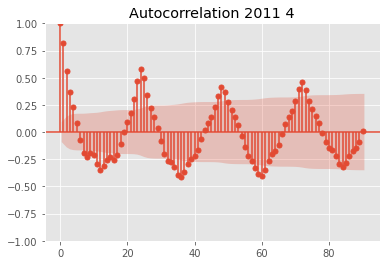

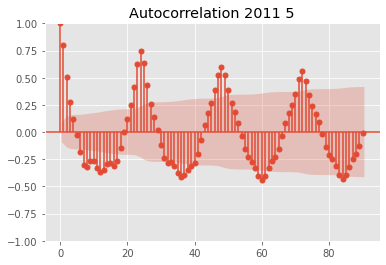

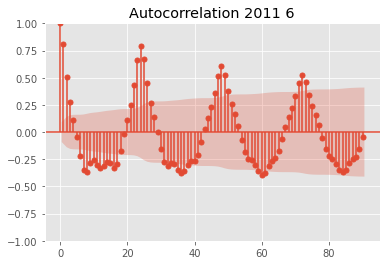

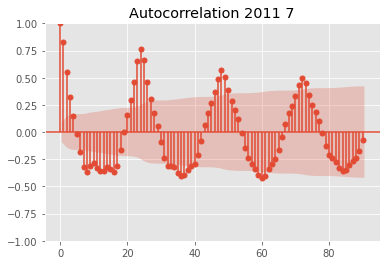

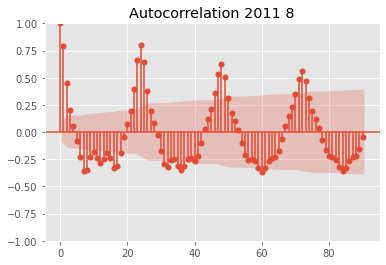

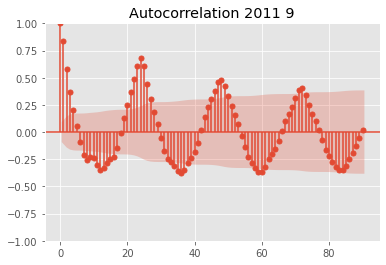

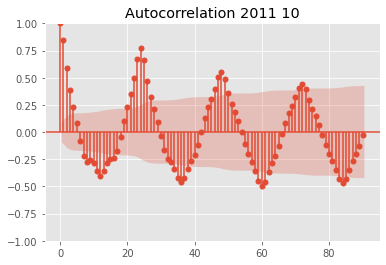

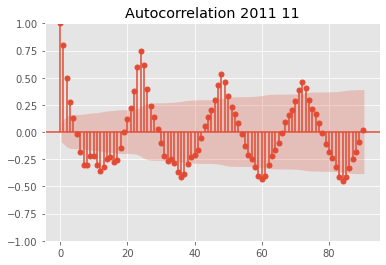

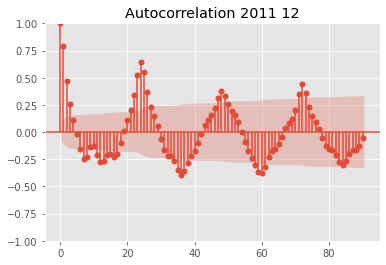

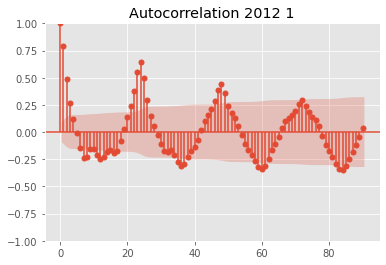

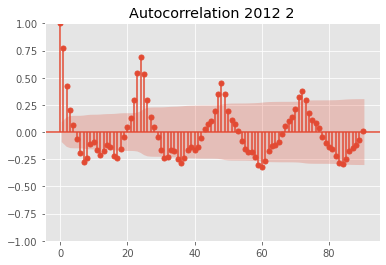

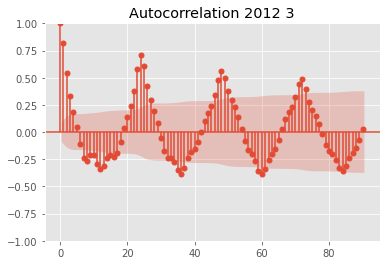

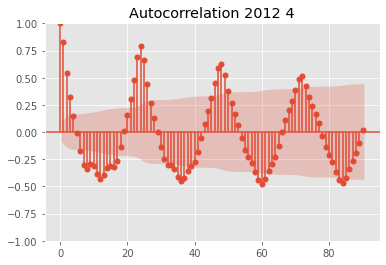

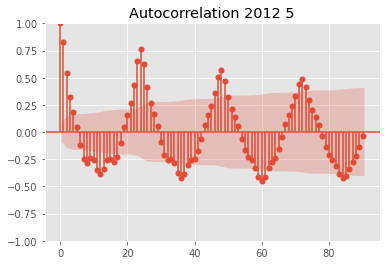

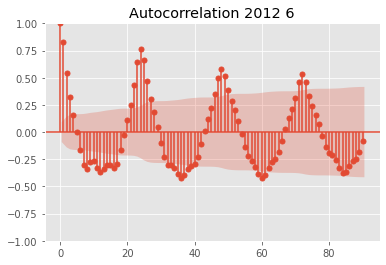

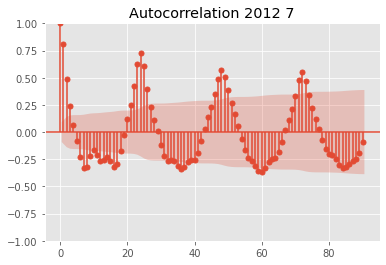

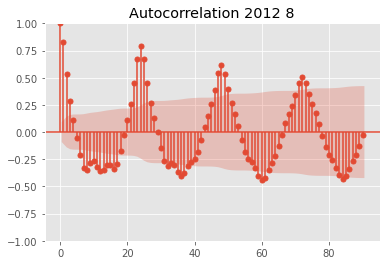

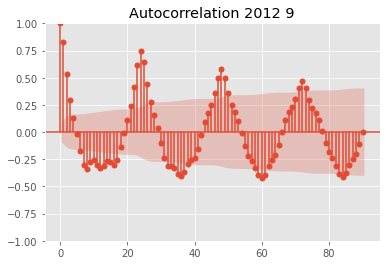

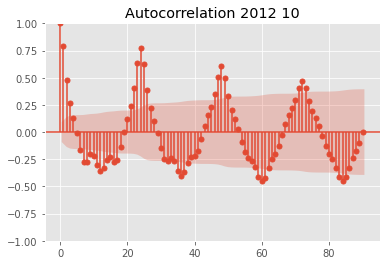

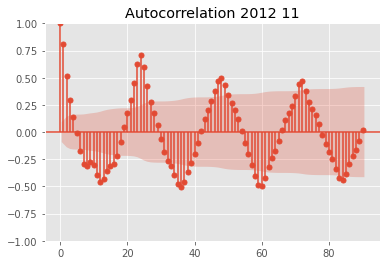

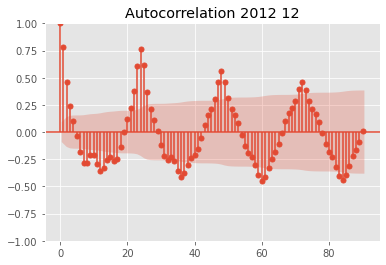

In [107]:
# Plot the autocorrelation function
for c in calendar:
    sm.graphics.tsa.plot_acf(select_train(c[0], c[1])['count'], lags=90, alpha=0.05, title=f"Autocorrelation {c[0]} {c[1]}");

### ***4. Example for January 2011*** ###

---

Plot train dataset

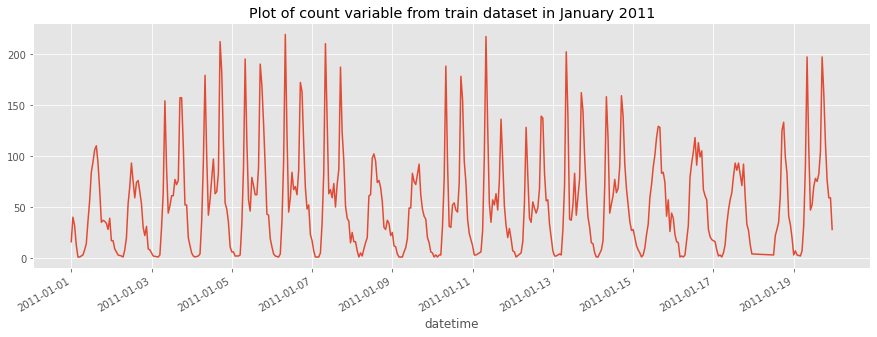

In [177]:
df_month = select_train(2011,1) # January 2011 train data
df_month_test = select_test(2011,1) # January 2011 test dataset 

df_month['count'].plot(figsize = (15,5))
plt.title('Plot of count variable from train dataset in January 2011');

Split data into X and y

In [178]:
X = df_month.drop('count', axis = 1)
y = np.array(df_month['count']).reshape(-1,1)

X.shape, y.shape

((431, 10), (431, 1))

Scale X and y

In [179]:
# Large values can slow down the learning and convergence of LSTM network
# so a scaler is needed. MinMaxScaler is chosen with range from 0 to 1 to preven
# the accurance of negative values. This does not prevent however an error when calculating
# sqrt for  metrics like rmsle, rmse etc... because our prediction can be negative.
scaler = MinMaxScaler(feature_range=(0, 1))
X_trans = scaler.fit_transform(X)
y_trans = scaler.fit_transform(y)

In [180]:
X_trans.shape

(431, 10)

Build trainX and trainY for LSTM

In [181]:
n_future = 1 # predict 1 step into the future...
n_past = 24 # ...based on 24 past steps

In [182]:
trainX = []; trainY = []
for i in range(n_past, len(X_trans) - n_future + 1):
    trainX.append(X_trans[i - n_past:i, 0:X_trans.shape[1]])
    trainY.append(y_trans[i + n_future-1:i + n_future,0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [183]:
trainX.shape, trainY.shape

((407, 24, 10), (407, 1))

Let's see whats inside trainX without the scaler

---

The first element of trainX consists of 24 previous elements each containint 10 variables

In [129]:
temp_trainX = []; temp_trainY = []
for i in range(n_past, len(X) - n_future + 1):
    temp_trainX.append(np.array(X)[i - n_past:i, 0:np.array(X).shape[1]])
    temp_trainY.append(y[i + n_future-1:i + n_future,0])
temp_trainX, temp_trainY = np.array(temp_trainX), np.array(temp_trainY)

In [139]:
temp_trainX[0][0]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.84 , 14.395, 81.   ,  0.   ,
        3.   , 13.   ])

In [140]:
temp_trainX[0][1]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.02 , 13.635, 80.   ,  0.   ,
        8.   , 32.   ])

In [141]:
df_train

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
...                     ...      ...         ...      ...    ...     ...   
2012-12-19 19:00:00       4        0           1        1  15.58  19.695   
2012-12-19 20:00:00       4        0           1        1  14.76  17.425   
2012-12-19 21:00:00       4        0           1        1  13.94  15.910   
2012-12-19 22:00:00       4        0           1        1  13.94  17.425   
2012-12-19 23:00:00       4        0           1        1  13.12  16.665   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81     0.0000       3          13     16  
2011-01-01 01:00:00        80     0.0000       8          32     40  
2011-01-01 02:00:00        80     0.0000       5          27     32  
2011-01-01 03:00:00        75     0.0000       3          10     13  
2011-01-01 04:00:00        75     0.0000       0           1      1  
...                       ...        ...     ...         ...    ...  
2012-12-19 19:00:00        50    26.0027       7         329    336  
2012-12-19 20:00:00        57    15.0013      10         231    241  
2012-12-19 21:00:00        61    15.0013       4         164    168  
2012-12-19 22:00:00        61     6.0032      12         117    129  
2012-12-19 23:00:00        66     8.9981       4          84     88  

[10886 rows x 11 columns]

In [142]:
temp_trainX[1][0]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.02 , 13.635, 80.   ,  0.   ,
        8.   , 32.   ])

In [143]:
temp_trainX[1][1]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.02 , 13.635, 80.   ,  0.   ,
        5.   , 27.   ])

In [144]:
del temp_trainX
del temp_trainY

---

In [184]:
# Our train dataset (for January 2011) has 407 hours
SPLIT = 300 # number of hours to be considered as train, the rest goes to valid

In [185]:
train_X = trainX[:SPLIT, :]
valid_X = trainX[SPLIT:, :]

train_y = trainY[:SPLIT, :]
valid_y = trainY[SPLIT:, :]

In [201]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences= True))
# model.add(Dropout(0.9))
# model.add(LSTM(32, activation='relu', return_sequences= True))
# model.add(LSTM(8, activation='relu', return_sequences= True))
model.add(LSTM(2, activation='relu', return_sequences= False))
# model.add(Dropout(0.1))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 24, 64)            19200     
                                                                 
 lstm_27 (LSTM)              (None, 2)                 536       
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 19,739
Trainable params: 19,739
Non-trainable params: 0
_________________________________________________________________


In [202]:
history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
17/17 [==============================] - 2s 34ms/step - loss: 0.0601 - val_loss: 0.0500
Epoch 2/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0504 - val_loss: 0.0493
Epoch 3/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0481 - val_loss: 0.0481
Epoch 4/50
17/17 [==============================] - 0s 13ms/step - loss: 0.0471 - val_loss: 0.0478
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0466 - val_loss: 0.0472
Epoch 6/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0461 - val_loss: 0.0448
Epoch 7/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0433 - val_loss: 0.0476
Epoch 8/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0453 - val_loss: 0.0429
Epoch 9/50
17/17 [==============================] - 0s 13ms/step - loss: 0.0429 - val_loss: 0.0395
Epoch 10/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0386 - val_loss: 0.0343
Epoch 11/

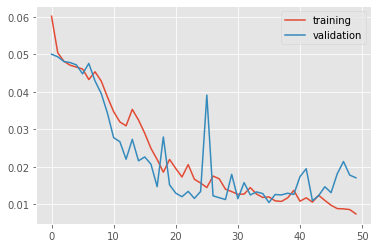

In [203]:
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend();

In [192]:
yhat = model.predict(valid_X) 
yhat[yhat<0] = 0

In [193]:
yhat

array([[0.01970244],
       [0.01928978],
       [0.00493875],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00528337],
       [0.16780072],
       [0.23513132],
       [0.10344955],
       [0.08104276],
       [0.14369312],
       [0.18690902],
       [0.20909438],
       [0.21599086],
       [0.24179918],
       [0.27247822],
       [0.2902007 ],
       [0.24473484],
       [0.21620445],
       [0.19544758],
       [0.16421787],
       [0.14593571],
       [0.11575549],
       [0.10259213],
       [0.07846059],
       [0.0521786 ],
       [0.03685661],
       [0.02791804],
       [0.00746831],
       [0.        ],
       [0.00390221],
       [0.02112771],
       [0.06324334],
       [0.10649329],
       [0.15511887],
       [0.19428152],
       [0.21296042],
       [0.22002865],
       [0.21360655],
       [0.21384466],
       [0.1940419 ],
       [0.17294405],
       [0.1305844 ],
       [0.09711885],
       [0.06948665],
       [0.04151445],
       [0.023

In [194]:
rmse = sqrt(mean_squared_error(valid_y, yhat))
rmsle = sqrt(mean_squared_log_error(valid_y, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test RMSLE: %.3f' % rmsle)

Test RMSE: 0.173
Test RMSLE: 0.132


Build LSTM model

In [198]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences= True))
# model.add(Dropout(0.9))
# model.add(LSTM(32, activation='relu', return_sequences= True))
# model.add(LSTM(8, activation='relu', return_sequences= True))
model.add(LSTM(2, activation='relu', return_sequences= False))
# model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 24, 64)            19200     
                                                                 
 lstm_25 (LSTM)              (None, 2)                 536       
                                                                 
 dense_12 (Dense)            (None, 1)                 3         
                                                                 
Total params: 19,739
Trainable params: 19,739
Non-trainable params: 0
_________________________________________________________________


In [199]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
23/23 [==============================] - 2s 27ms/step - loss: 0.0510 - val_loss: 0.0533
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0462 - val_loss: 0.0484
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0431 - val_loss: 0.0496
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0396 - val_loss: 0.0477
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0354 - val_loss: 0.0395
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0308 - val_loss: 0.0416
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0288 - val_loss: 0.0337
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0264 - val_loss: 0.0361
Epoch 9/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0262 - val_loss: 0.0327
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0251 - val_loss: 0.0381
Epoch 11/

Plot train and valid loss

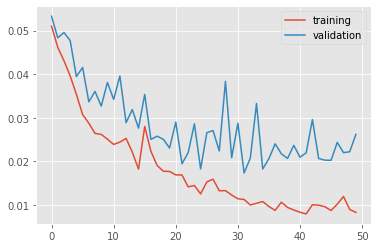

In [200]:
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend();

Get dates for forecasting

In [204]:
n_predict = select_test(2011,1).shape[0] 
forecast_period_dates = df_month_test[:n_predict].index
forecast_period_dates

DatetimeIndex(['2011-01-20 00:00:00', '2011-01-20 01:00:00',
               '2011-01-20 02:00:00', '2011-01-20 03:00:00',
               '2011-01-20 04:00:00', '2011-01-20 05:00:00',
               '2011-01-20 06:00:00', '2011-01-20 07:00:00',
               '2011-01-20 08:00:00', '2011-01-20 09:00:00',
               ...
               '2011-01-31 14:00:00', '2011-01-31 15:00:00',
               '2011-01-31 16:00:00', '2011-01-31 17:00:00',
               '2011-01-31 18:00:00', '2011-01-31 19:00:00',
               '2011-01-31 20:00:00', '2011-01-31 21:00:00',
               '2011-01-31 22:00:00', '2011-01-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=257, freq=None)

In [222]:
n_predict

257

Perform forecast

In [205]:
forecast = model.predict(trainX[-n_predict:])

In [206]:
forecast_copies = np.repeat(forecast, X.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

# np.repeat(forecast, X.shape[1], axis=-1)[:,0]
# transforms output from
# array([[0.3767641 ],
#       [0.41019553],
#       [0.41848484],
#       [0.3720415 ],
#       [0.3122611 ], ...
# to
# array([0.3767641 , 0.41019553, 0.41848484, 0.3720415 , 0.3122611 ,...

Put predicted values into a dataframe

In [212]:
df_forecast = pd.DataFrame({'datetime': np.array(forecast_period_dates), 'count': y_pred_future})
df_forecast.index = pd.to_datetime(df_forecast['datetime'])
del df_forecast['datetime']
df_forecast

count
datetime                      
2011-01-20 00:00:00  83.134567
2011-01-20 01:00:00  90.422623
2011-01-20 02:00:00  92.229691
2011-01-20 03:00:00  82.105042
2011-01-20 04:00:00  69.072922
...                        ...
2011-01-31 19:00:00  83.293137
2011-01-31 20:00:00  50.858387
2011-01-31 21:00:00   6.066316
2011-01-31 22:00:00   4.123833
2011-01-31 23:00:00   4.037727

[257 rows x 1 columns]

Plot traning and predicted data

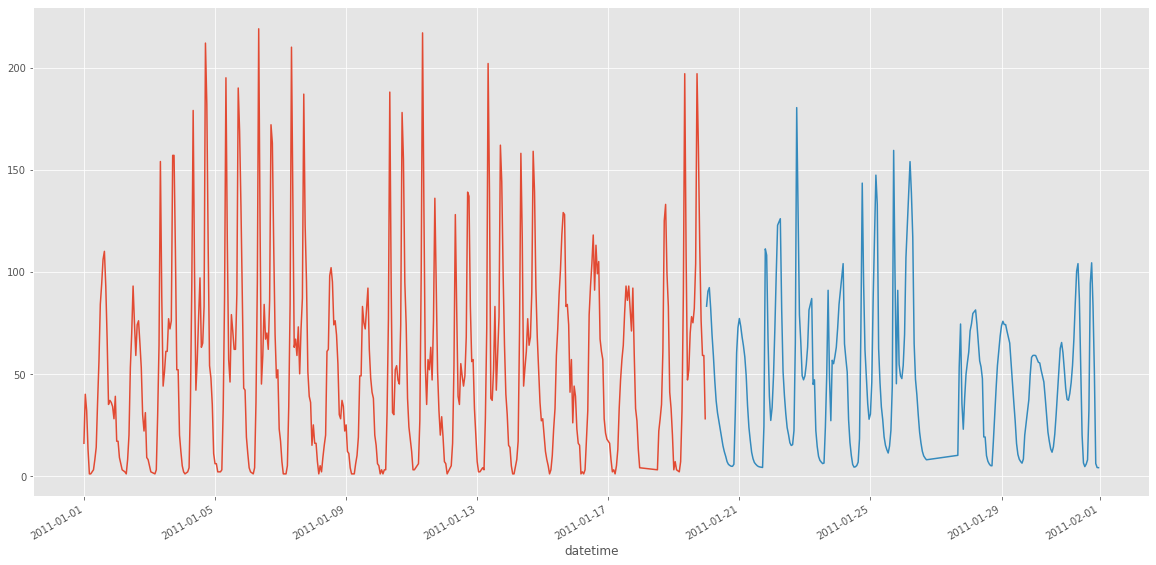

In [213]:
plt.figure(figsize=(20,10))
df_month['count'].plot()
df_forecast['count'].plot();

### ***5. Adapt steps for full 2 years*** ###

---

In [308]:
sample_model = Sequential([
    LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
    # Bidirectional(LSTM(2, activation='relu', return_sequences= True)),
    # LSTM(32, activation='relu', return_sequences= True),
    LSTM(2, activation='relu', return_sequences= False),
    Dense(train_y.shape[1])
])

In [309]:
models = [
    sample_model,
]

In [312]:
def run_experiments(n_future = 24, train_valid_n_split = 300):
    years = [2011, 2012] # all years
    months = list(range(1, 13)) # months from 1 to 12
    calendar = list(product(years, months))

    scaler = MinMaxScaler(feature_range=(0, 1))

    def rescale(forecast):
        forecast_copies = np.repeat(forecast, df_train.shape[1], axis = -1)
        y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
        return y_pred_future

    def make_trainX_trainY(X_trans, y_trans, n_future):
        trainX = []; trainY = []
        for i in range(n_past, len(X_trans) - n_future + 1):
            trainX.append(X_trans[i - n_past:i, 0:X_trans.shape[1]])
            trainY.append(y_trans[i + n_future-1:i + n_future,0])
        trainX, trainY = np.array(trainX), np.array(trainY)
        return trainX, trainY

    def plot_current_and_forect(year, month, y_pred_future):
        df_month_test = select_test(year, month)
        n_predict = df_month_test.shape[0]
        forecast_period_dates = df_month_test[:n_predict].index

        df_forecast = pd.DataFrame({'datetime': np.array(forecast_period_dates), 'count': y_pred_future})
        df_forecast.index = pd.to_datetime(df_forecast['datetime'])
        del df_forecast['datetime']

        plt.figure(figsize=(20,10))
        plt.title(f'Forecast for {year}-{month}')
        df_month['count'].plot()
        df_forecast['count'].plot();


    for c in calendar:
        year = c[0]
        month = c[1]

        print('='*30)
        print(f'{year}-{month}')
        print('='*30)
        
        df_month = select_train(year, month)

        X = df_month.drop('count', axis = 1)
        y = np.array(df_month['count']).reshape(-1, 1)

        X_trans = scaler.fit_transform(X)
        y_trans = scaler.fit_transform(y)

        trainX, trainY = make_trainX_trainY(X_trans, y_trans, n_future=n_future)

        train_X = trainX[:train_valid_n_split, :]
        valid_X = trainX[train_valid_n_split:, :]

        train_y = trainY[:train_valid_n_split, :]
        valid_y = trainY[train_valid_n_split:, :]
        
        for model in models:
            model.compile(optimizer='adam', loss='mse', metrics = ['mse', 'mae', 'msle'])
            history = model.fit(train_X, train_y, epochs=50, batch_size=256, validation_data=(valid_X, valid_y), verbose=0)
            plt.figure()
            plt.plot(history.history['msle'], label = 'training')
            plt.plot(history.history['val_msle'], label = 'validation')
            plt.title(f'MSLE for {year}-{month}')
            plt.legend()
            plt.show();
            print('MSLE',max(history.history['val_msle']))

            n_predict = select_test(year, month).shape[0]

            forecast = model.predict(trainX[-n_predict:])
            y_pred_future = rescale(forecast)
            plot_current_and_forect(year, month, y_pred_future)

2011-1


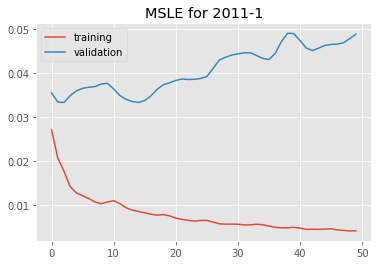

MSLE 0.04898250848054886
2011-2


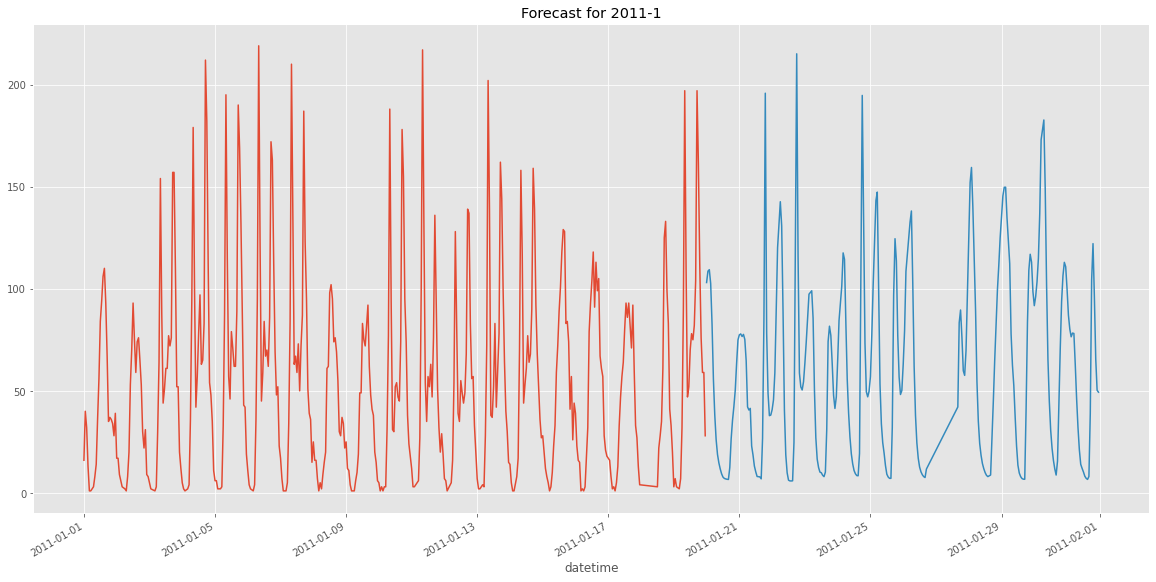

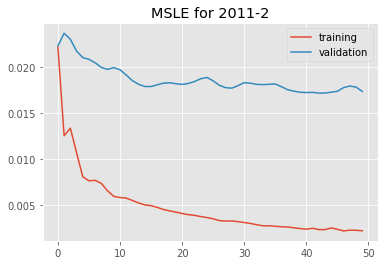

MSLE 0.023671580478549004
2011-3


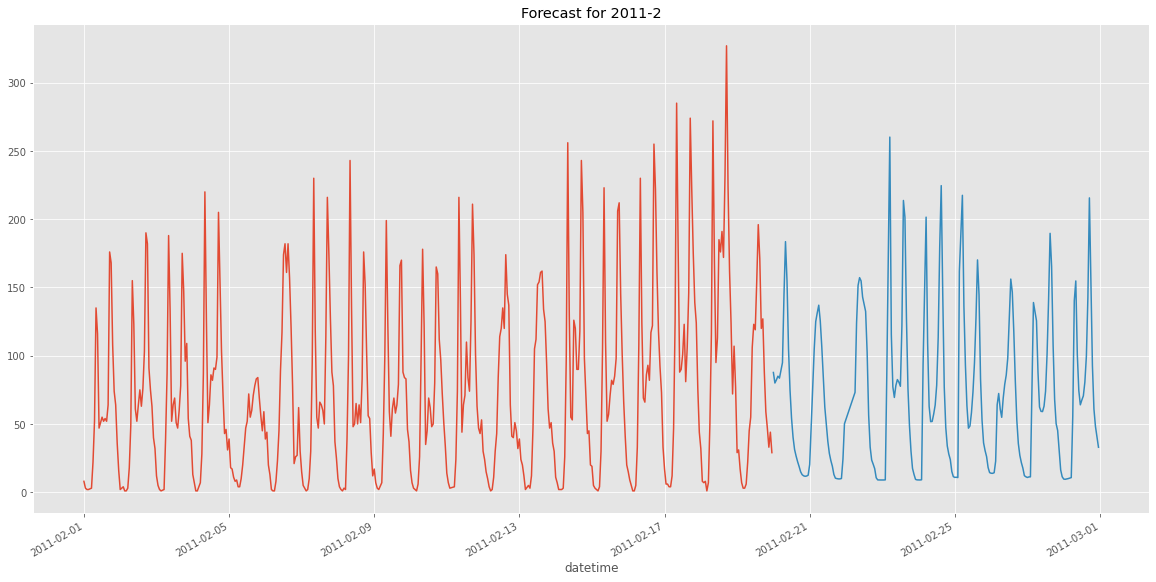

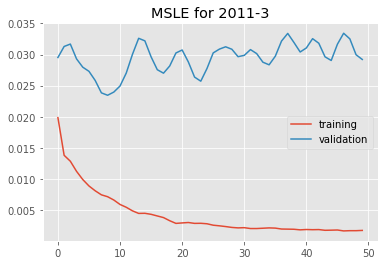

MSLE 0.033421363681554794
2011-4


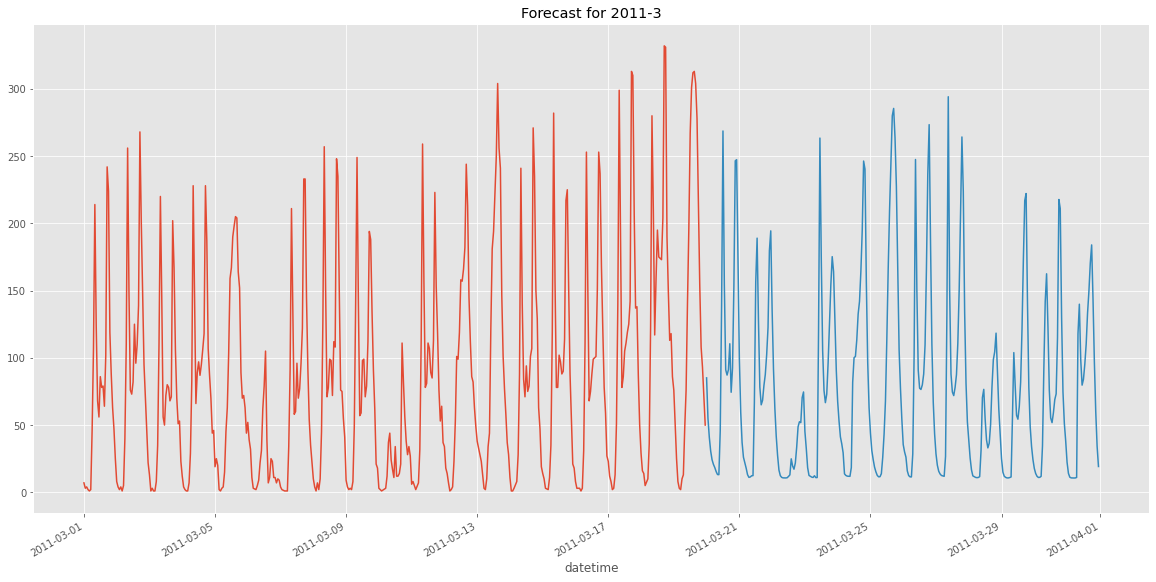

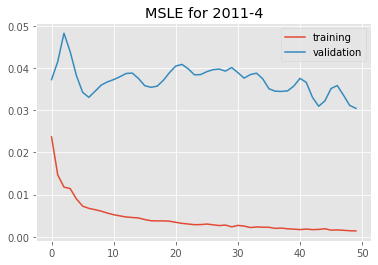

MSLE 0.048277564346790314
2011-5


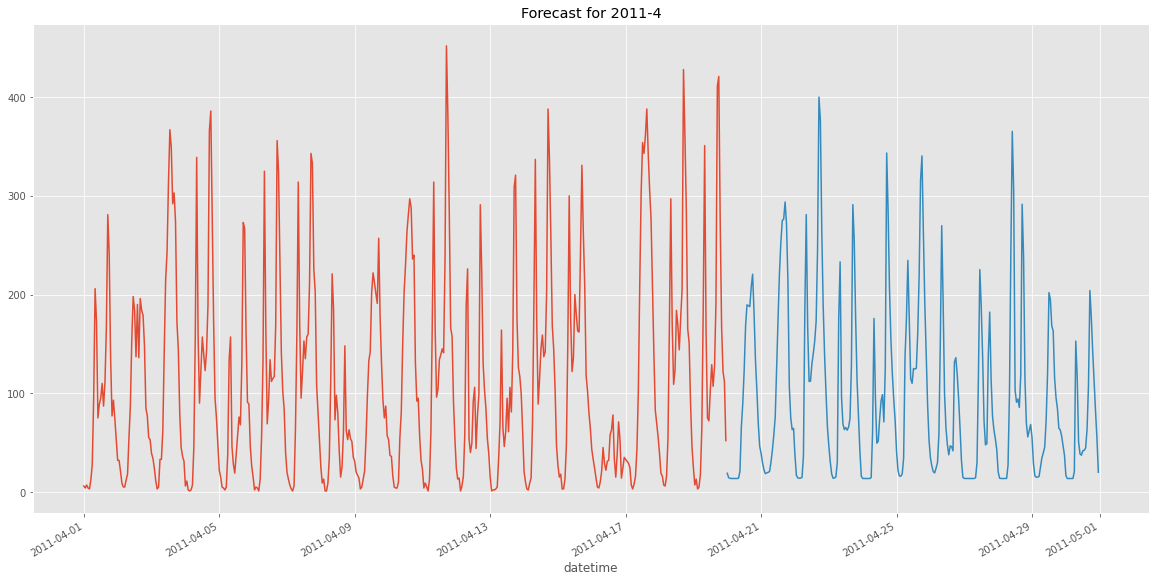

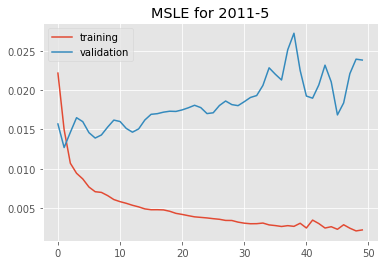

MSLE 0.027239106595516205
2011-6


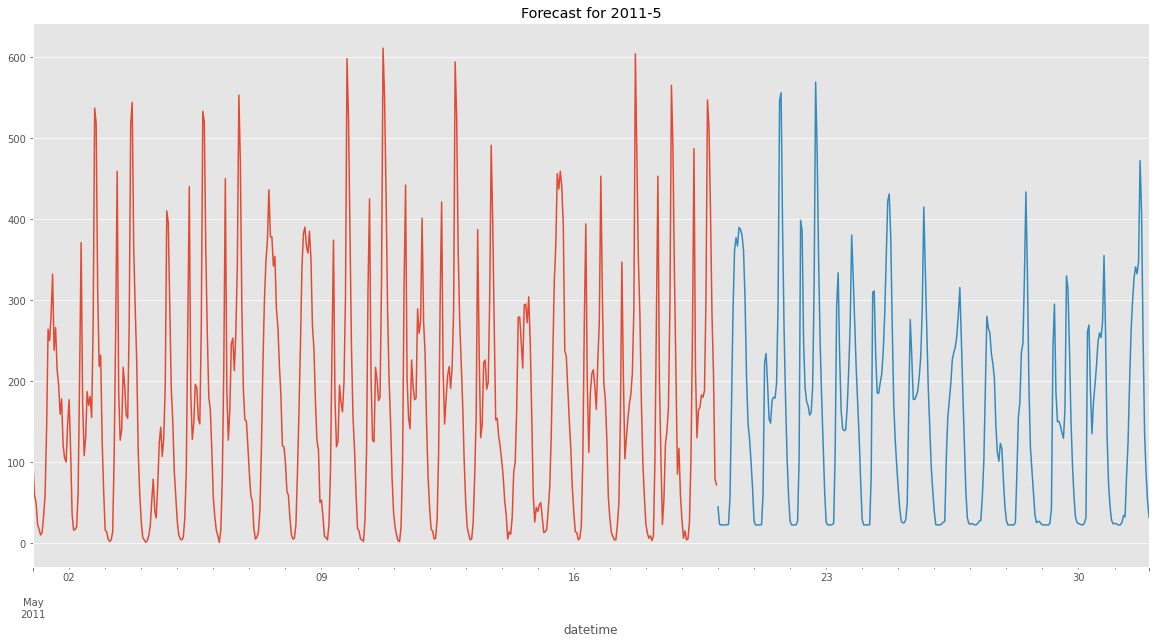

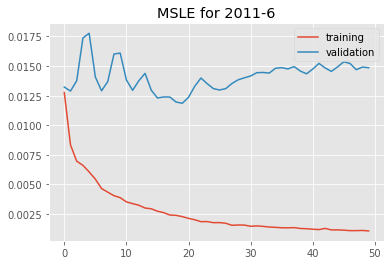

MSLE 0.017771540209650993
2011-7


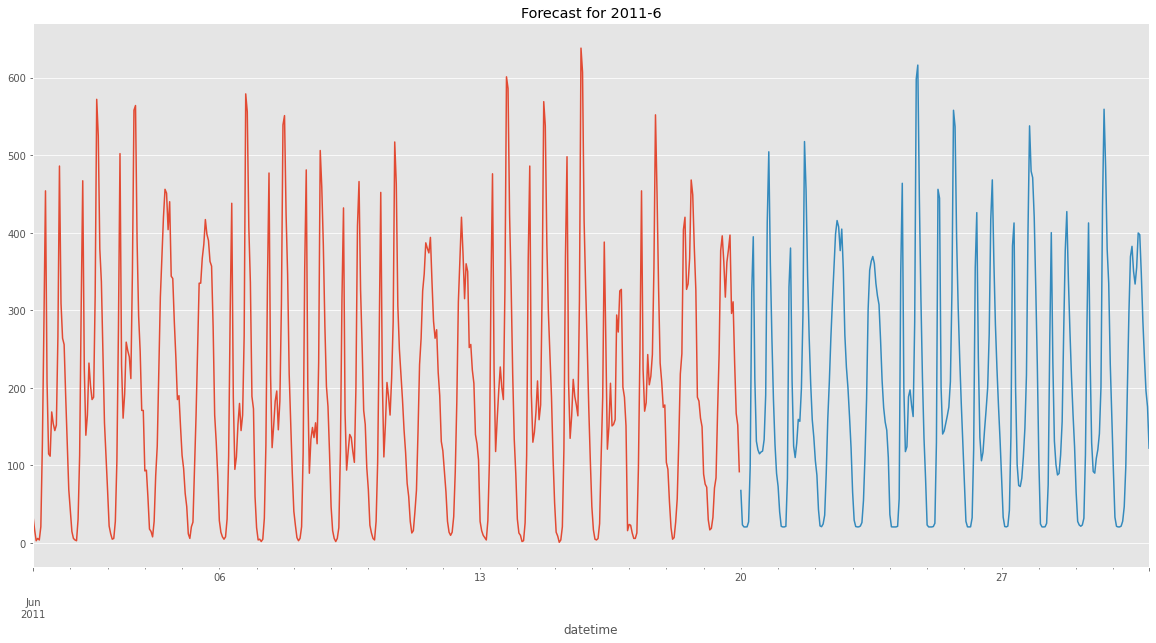

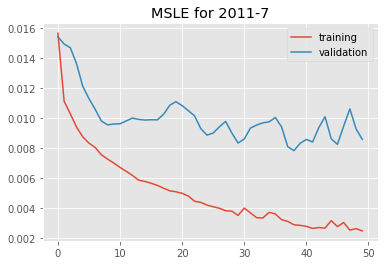

MSLE 0.015436743386089802
2011-8


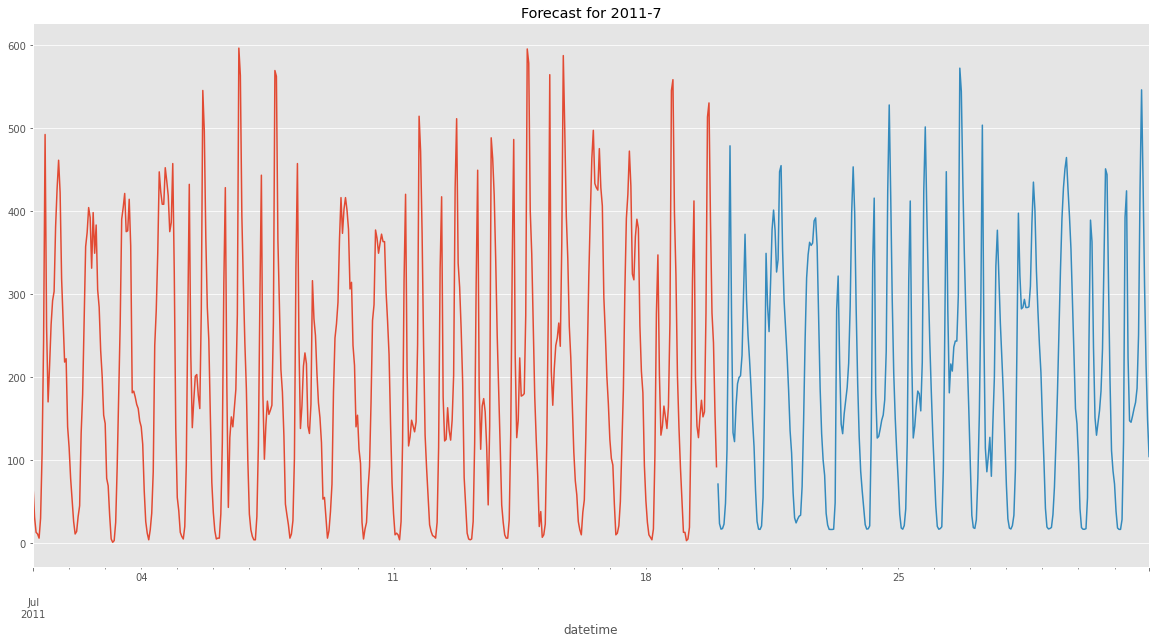

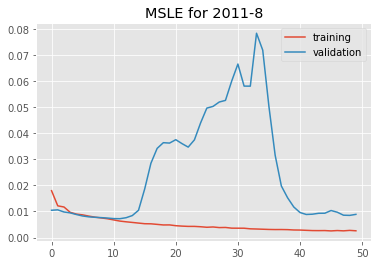

MSLE 0.07829860597848892
2011-9


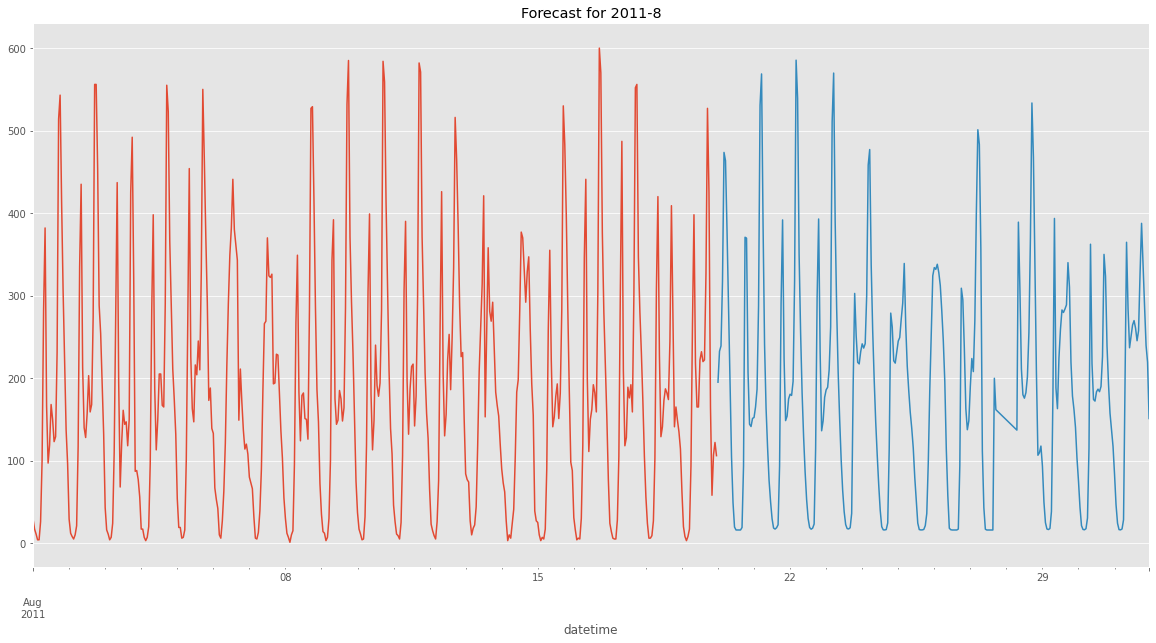

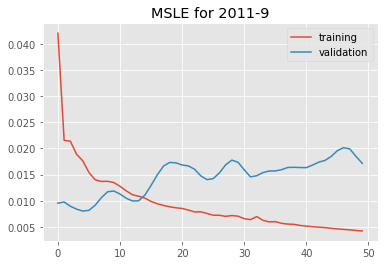

MSLE 0.020160425454378128
2011-10


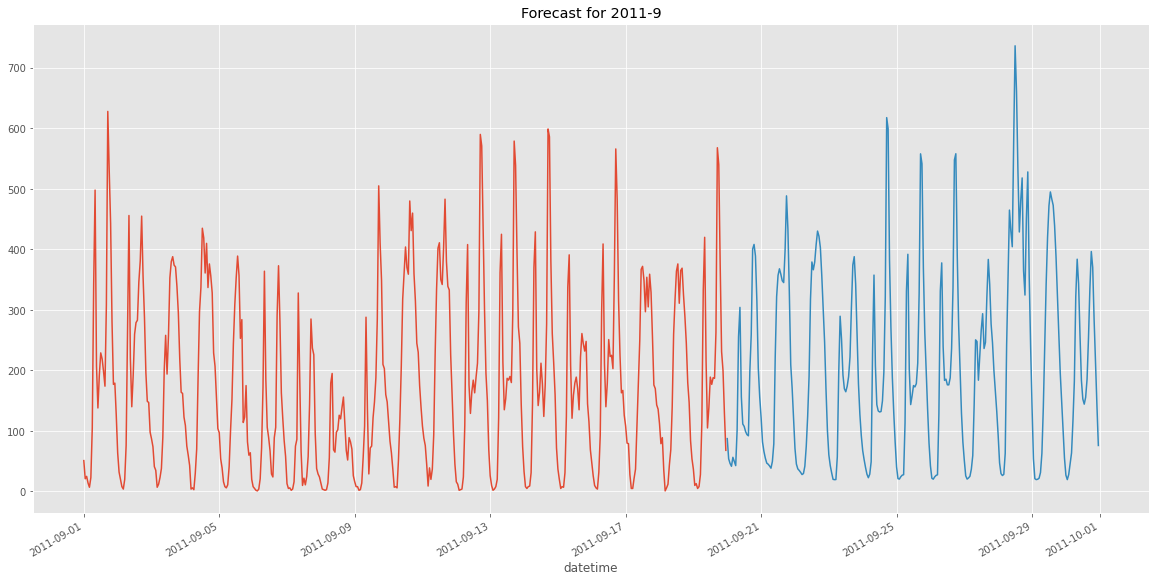

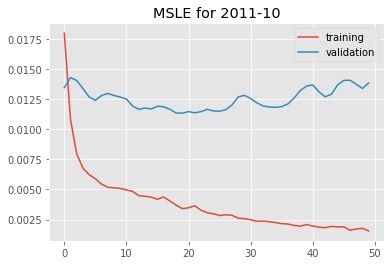

MSLE 0.01428337674587965
2011-11


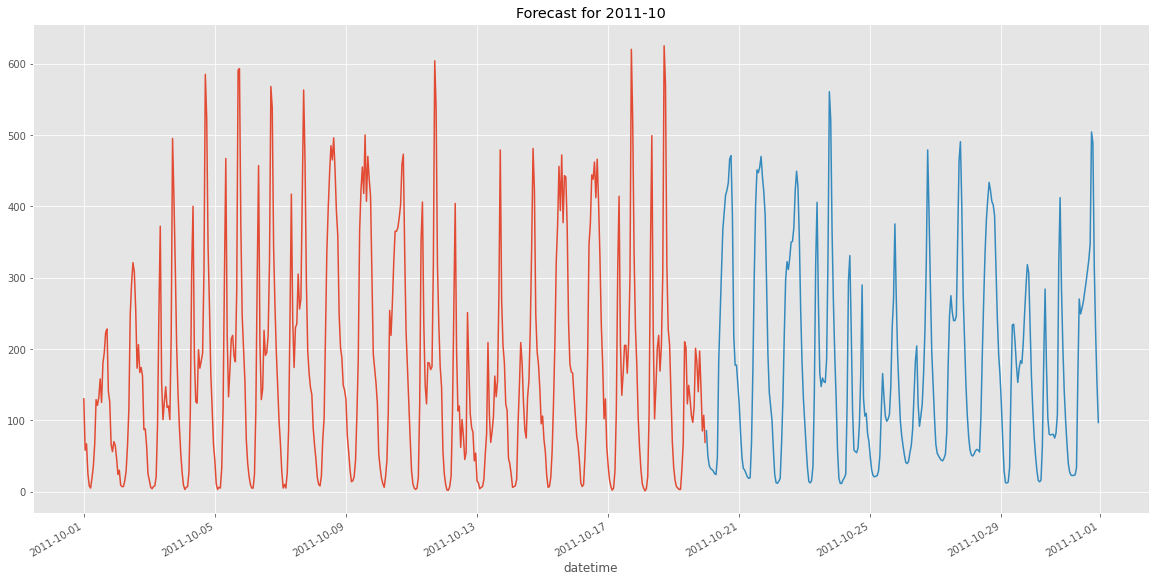

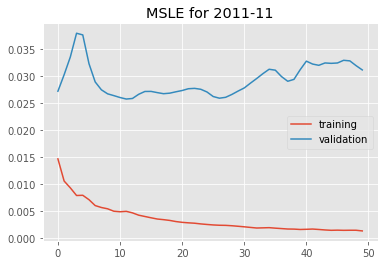

MSLE 0.03799005225300789
2011-12


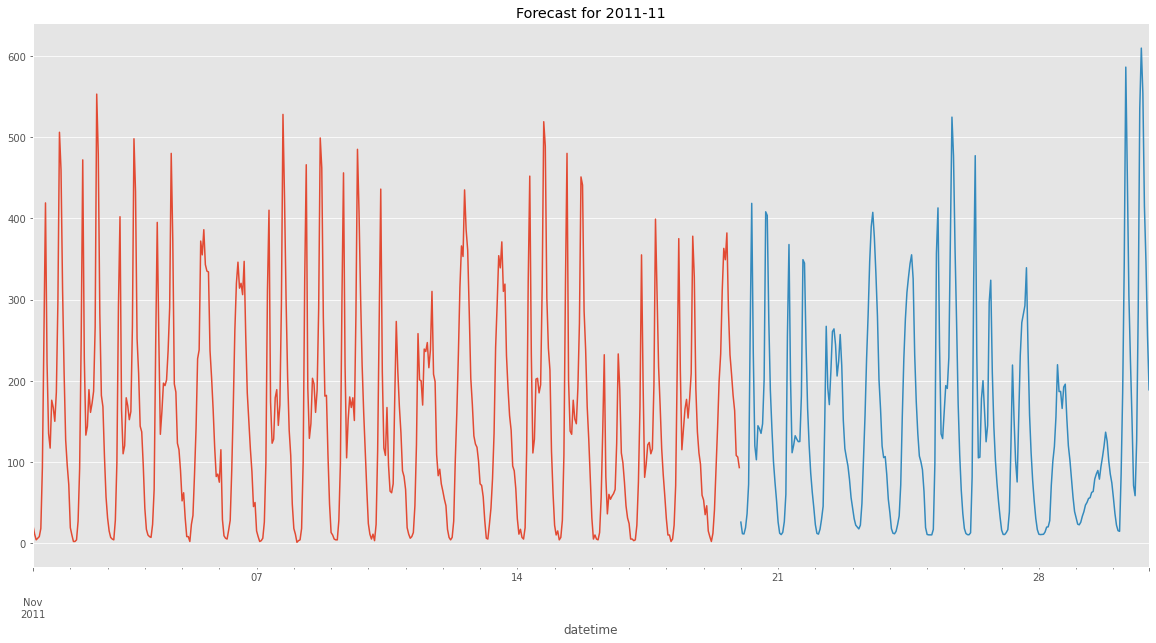

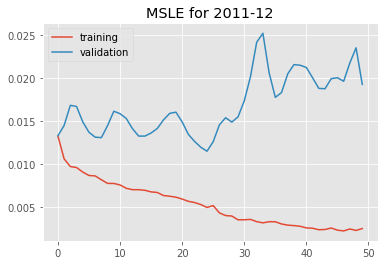

MSLE 0.02525227889418602
2012-1


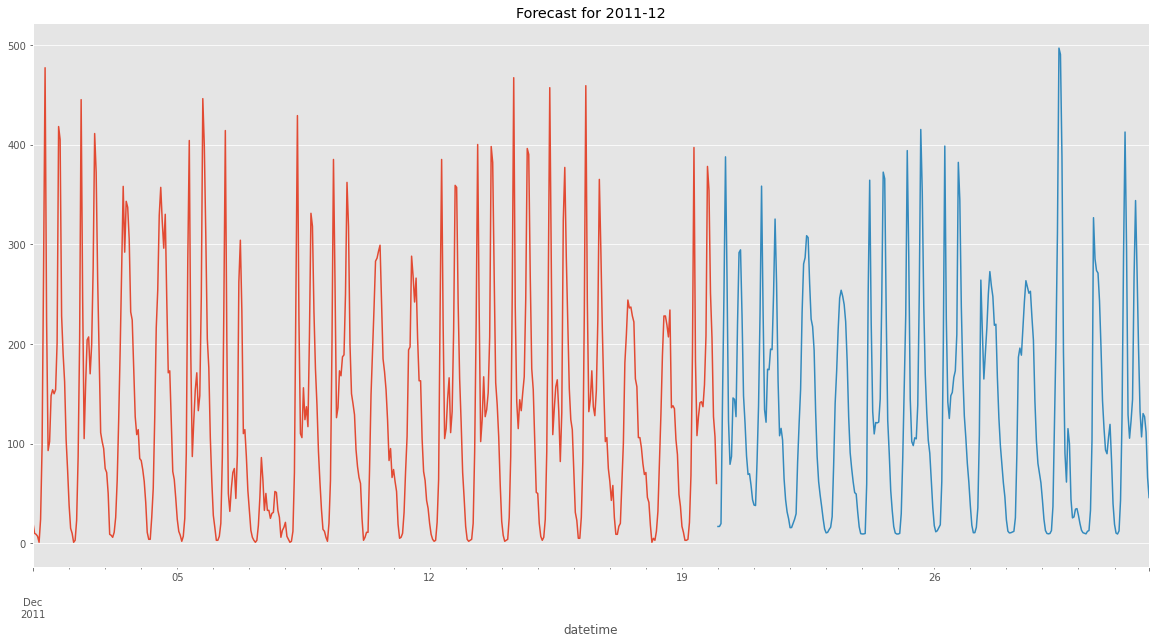

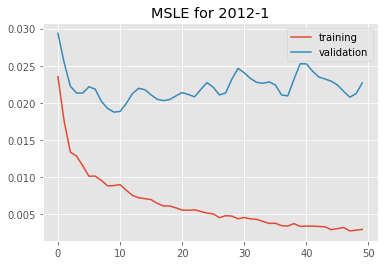

MSLE 0.029381725937128067
2012-2


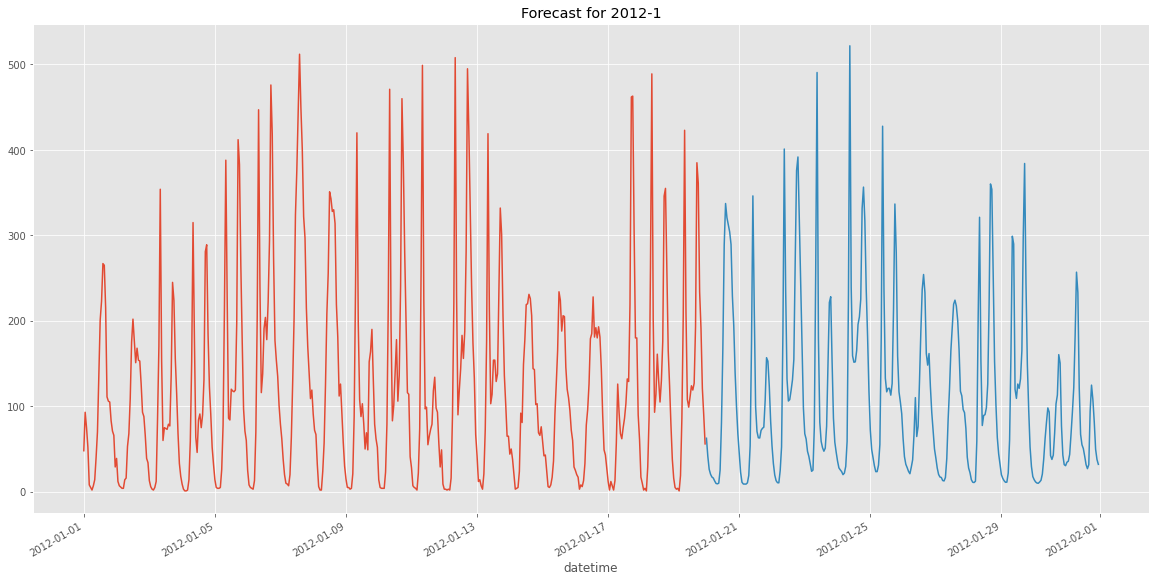

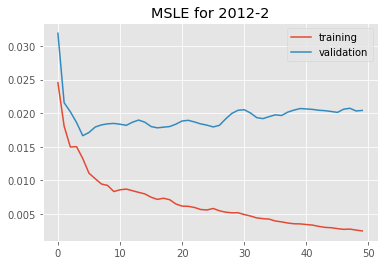

MSLE 0.031910233199596405
2012-3


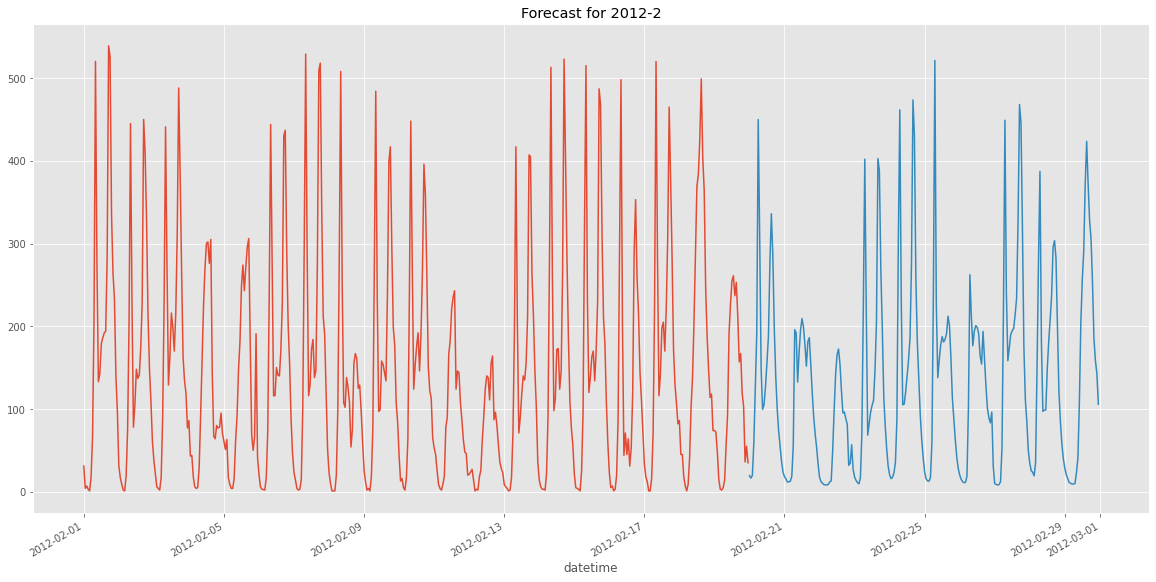

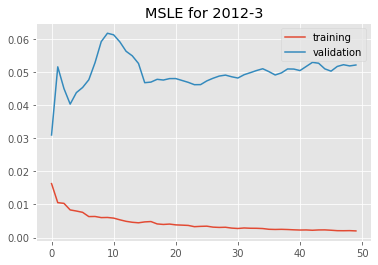

MSLE 0.06166929379105568
2012-4


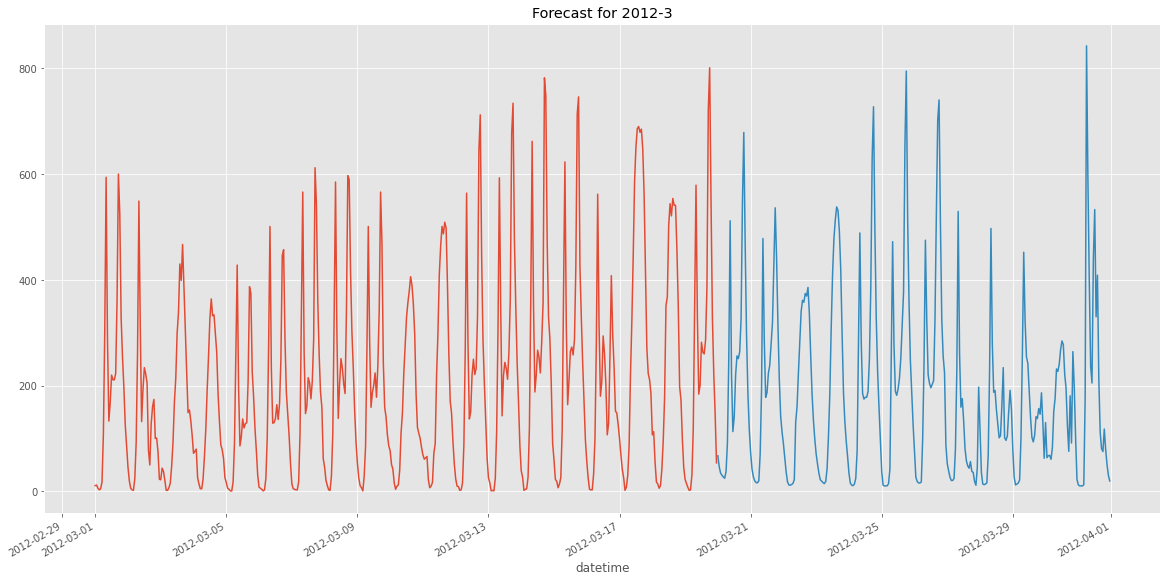

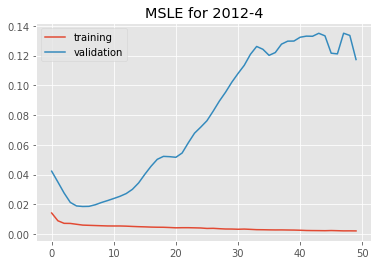

MSLE 0.1350163221359253
2012-5


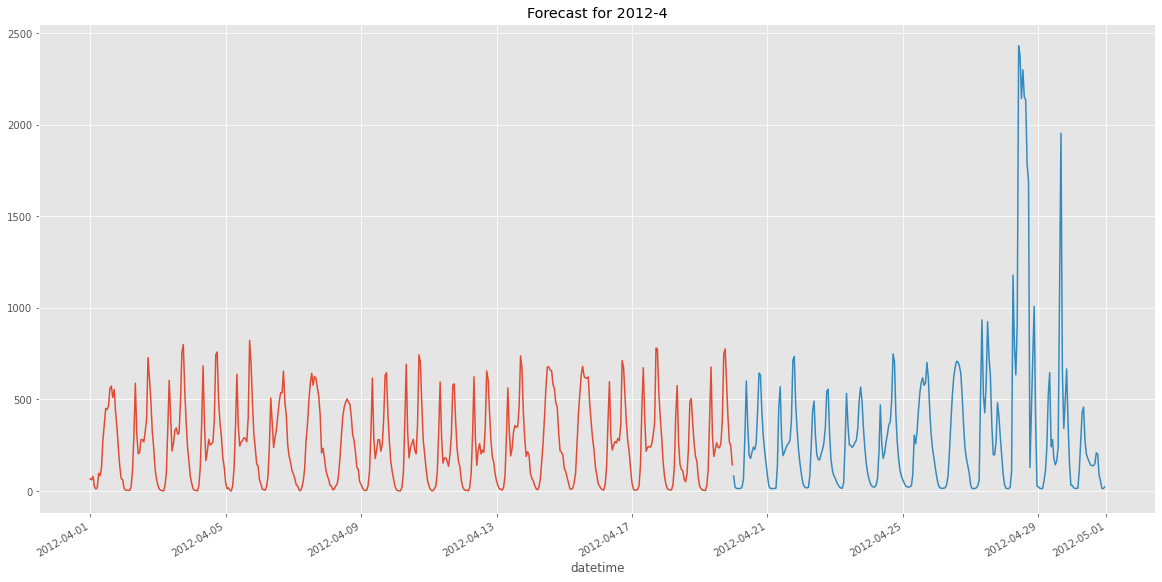

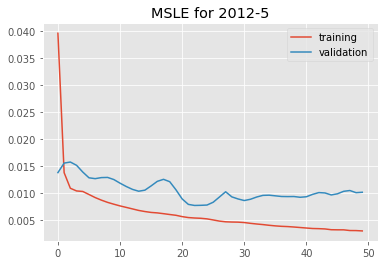

MSLE 0.015705328434705734
2012-6


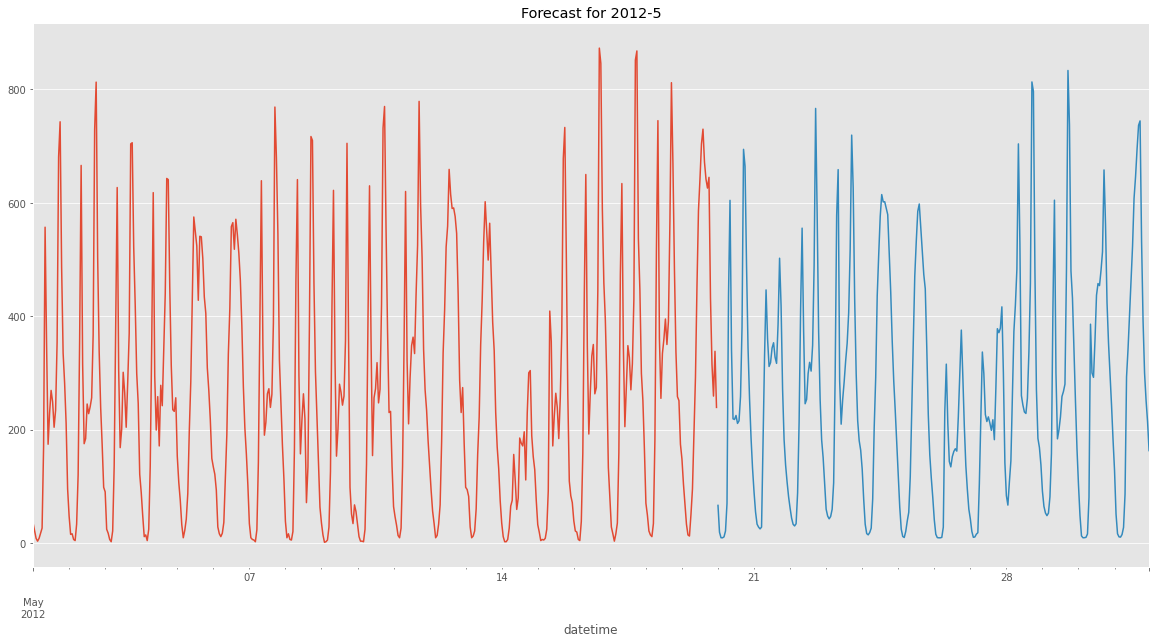

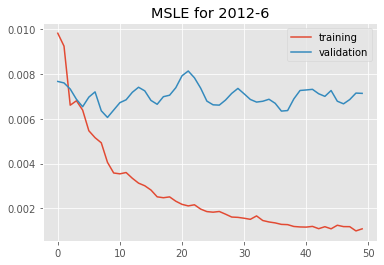

MSLE 0.008139082230627537
2012-7


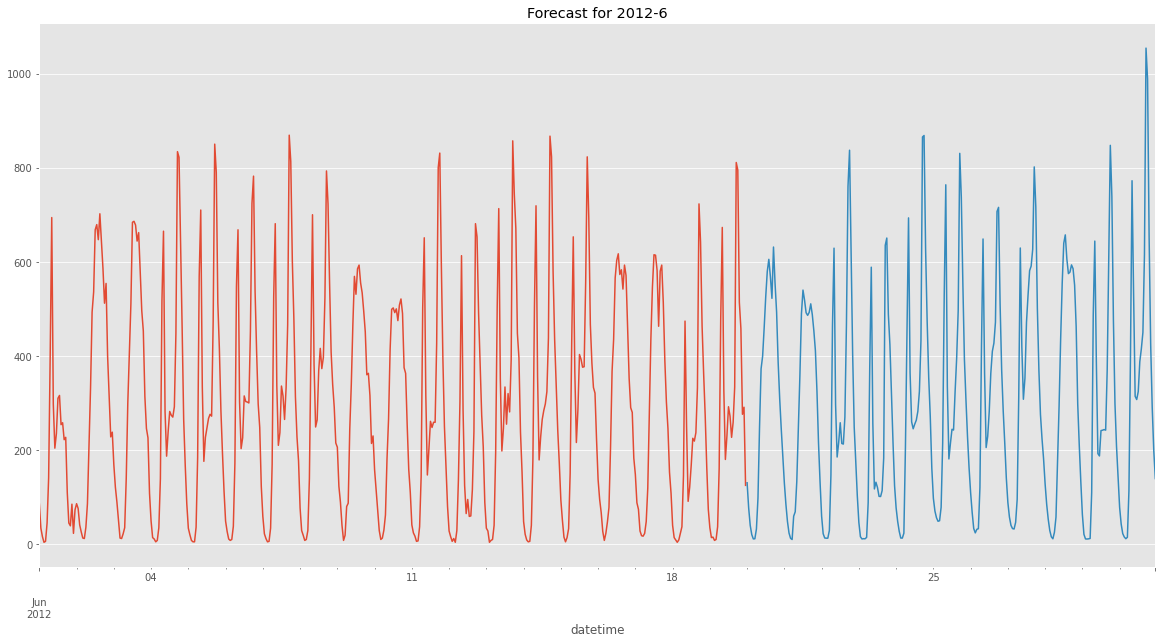

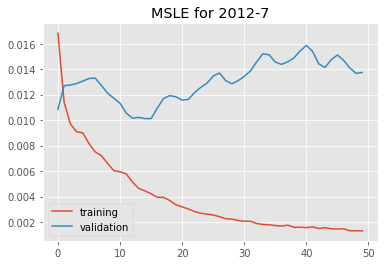

MSLE 0.01586553454399109
2012-8


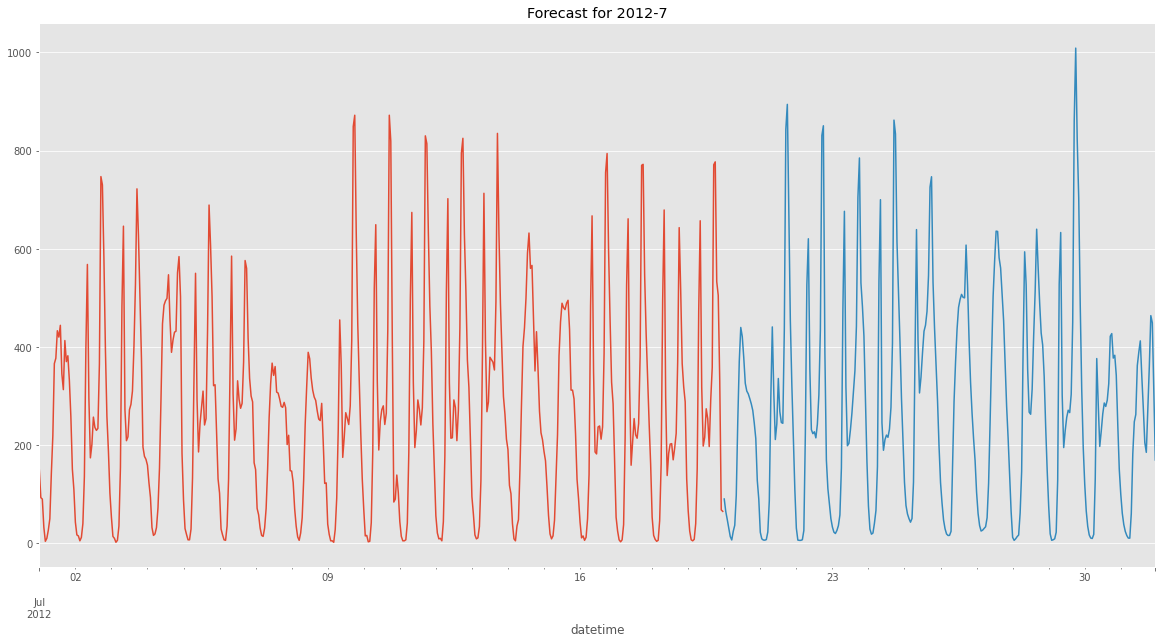

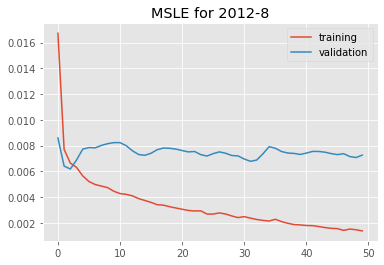

MSLE 0.008592929691076279
2012-9


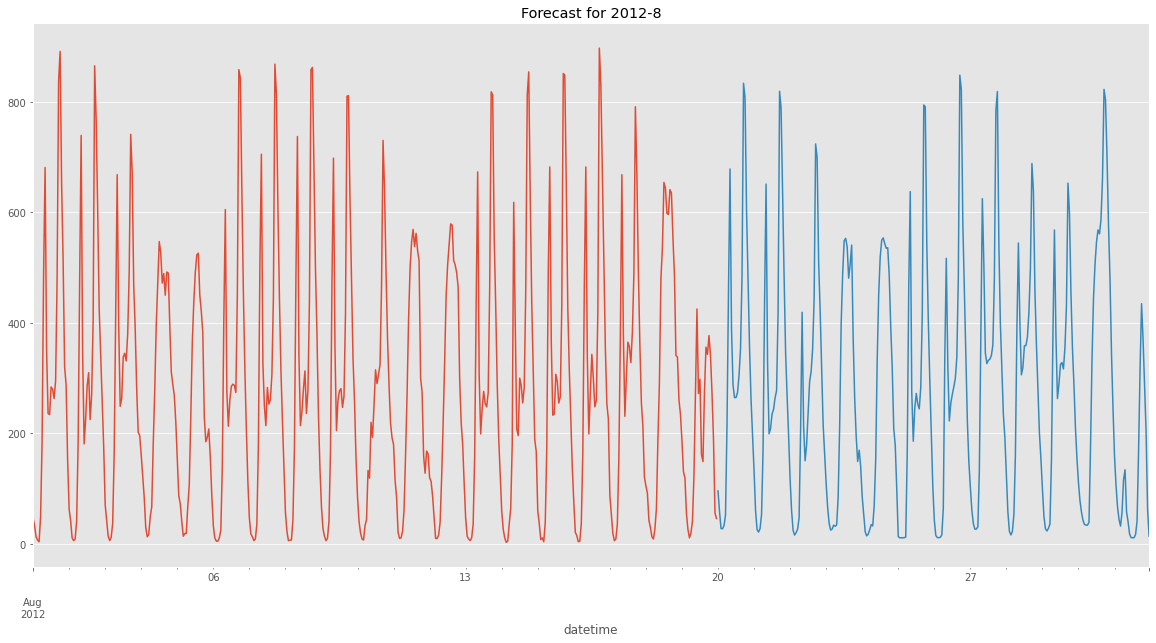

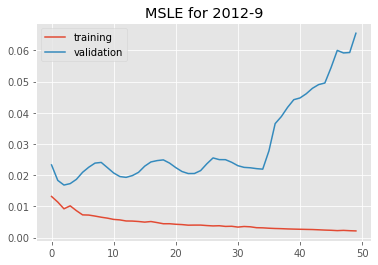

MSLE 0.06546523422002792
2012-10


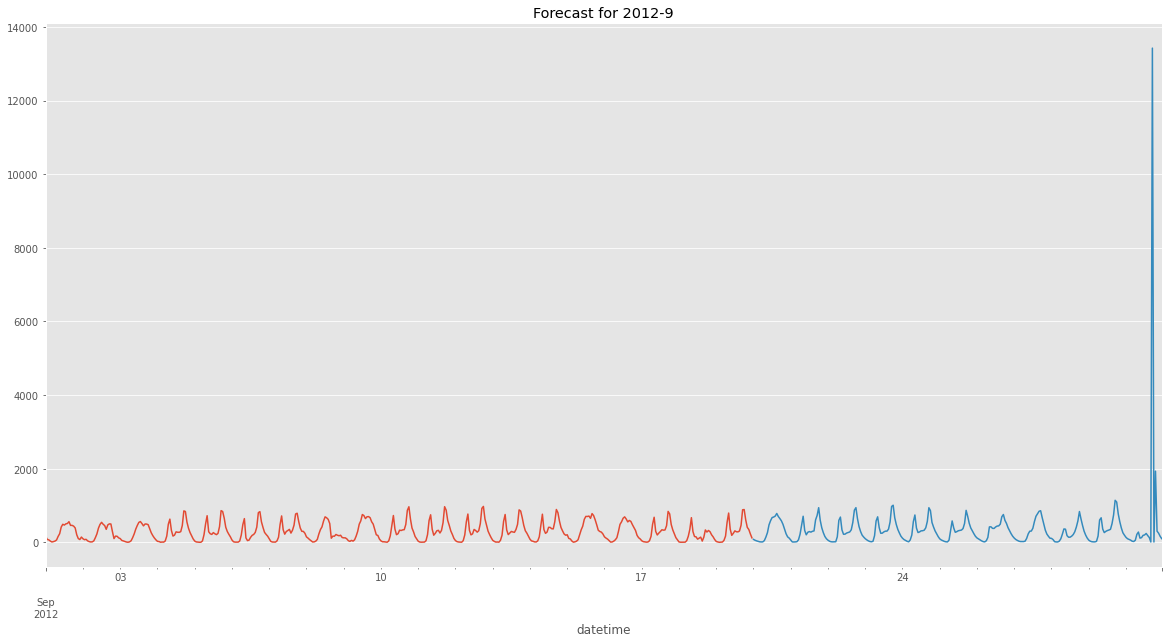

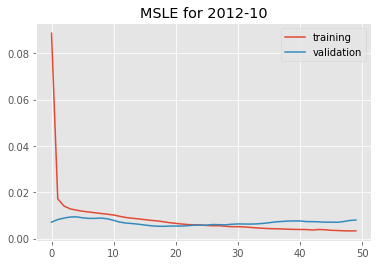

MSLE 0.009366330690681934
2012-11


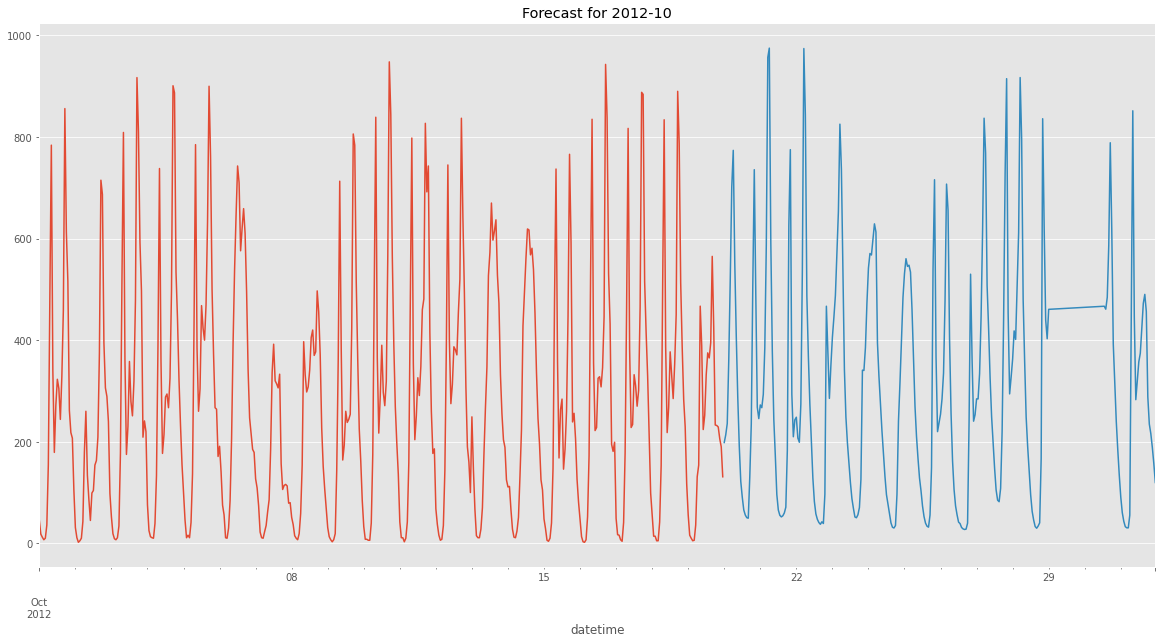

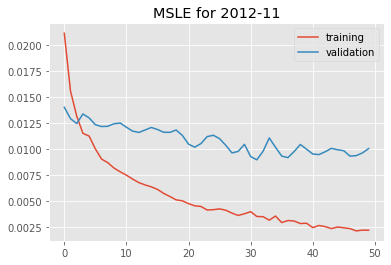

MSLE 0.014030598104000092
2012-12


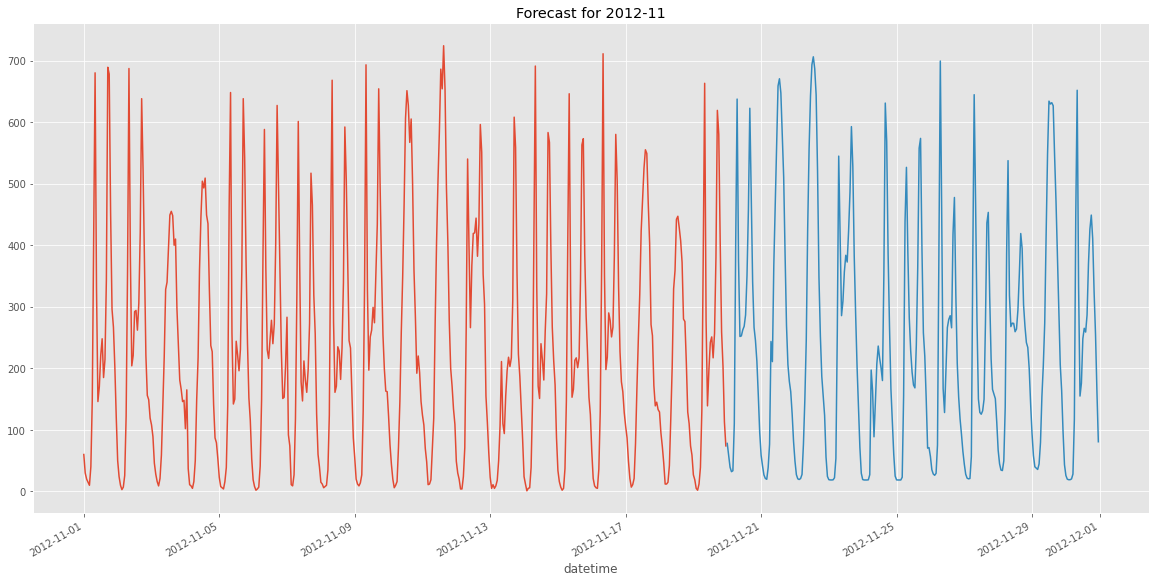

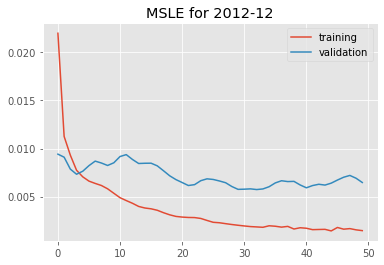

MSLE 0.009412960149347782


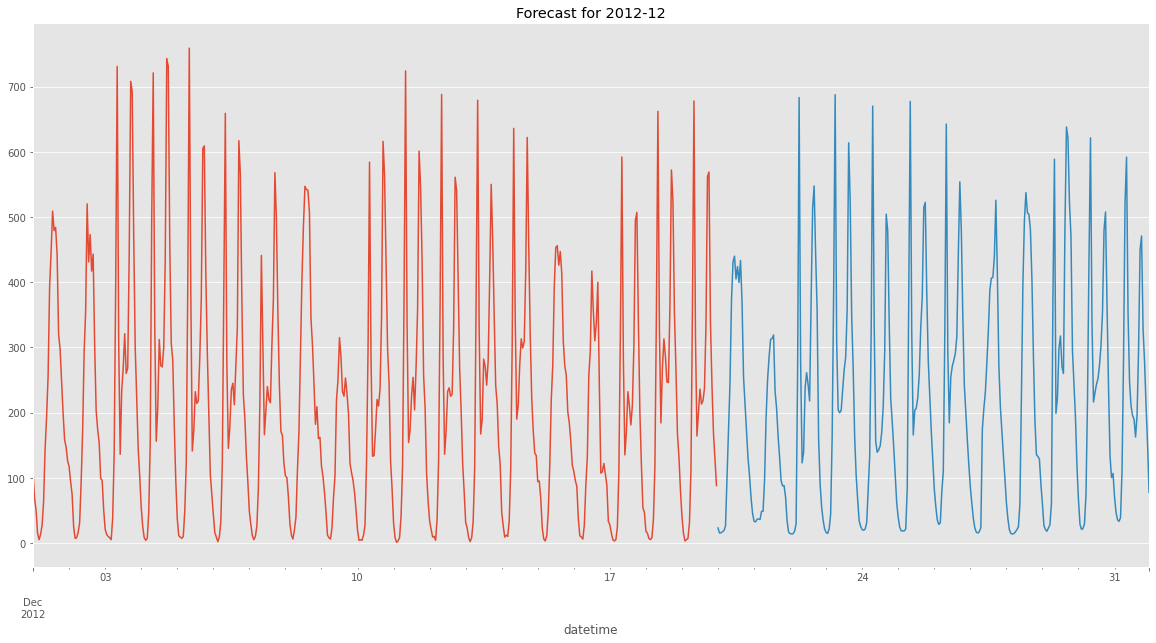

In [313]:
run_experiments()